In [1]:
%pip install --quiet jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
%load_ext sql
%matplotlib widget

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
%sql duckdb:///./382521.duckdb

Connecting to 'duckdb:///./382521.duckdb'

In [5]:
%sqlcmd tables

Name
Gateway
Site
Node
Message
Trace
Radio
Power_Consumption
Downlink_Event_Error_Message
Join_Message
Content_Message


In [6]:
%sql select * from Trace

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-02 10:44:44.111270,�'/!8@!8UP�����Join procedure succeededcreatin...
1,2,70B3D57ED005E88A,2023-11-02 10:44:44.111979,Sending: <3\n
2,3,70B3D57ED005E88A,2023-11-02 10:44:49.218133,"Startup done. Timings: sensor init: 14 ms, env..."
3,4,70B3D57ED005E88A,2023-11-02 10:44:49.220100,Main loop iteration\n
4,5,70B3D57ED005E88A,2023-11-02 10:44:49.222096,Running single blink...\n
...,...,...,...,...
602,603,70B3D57ED005E88A,2023-11-02 10:49:19.918121,collecting data from sensor lps22hb\n
603,604,70B3D57ED005E88A,2023-11-02 10:49:19.924045,Read value from Sensor lps22hb. Saving in env...
604,605,70B3D57ED005E88A,2023-11-02 10:49:19.926032,Execute Queries...\n
605,606,70B3D57ED005E88A,2023-11-02 10:49:19.928118,Sending Responses if any...\n


In [7]:
%sql nodes =<< select distinct * from Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board
0,70B3D57ED005E88A,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1


In [8]:

timestamps=%sql select timestamp from Power_Consumption 
#timestamps = timestamps["timestamp"].map(lambda x: x.isoformat())
%sql SUMMARIZE Power_Consumption

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,power_consumption_id,INTEGER,1,70299,69764,35150.0,20293.717623934608,17564,35584,52726,70299,0.0%
1,node_id,VARCHAR,70B3D57ED005E88A,70B3D57ED005E88A,1,None,None,None,None,None,70299,0.0%
2,timestamp,TIMESTAMP,2023-11-02 10:44:15.125855,2023-11-02 10:49:20.806185,68879,None,None,None,None,None,70299,0.0%
3,current,FLOAT,0.0,0.106124,958,0.05909485940287896,0.010744911694350429,0.055819220604975246,0.05633017759460929,0.05699887869180776,70299,0.0%
4,voltage,FLOAT,1.6175,4.92,134,4.854870017869494,0.12117060403119566,4.858749866485596,4.860000133514404,4.861249923706055,70299,0.0%
5,power,FLOAT,0.0,0.507302,341,0.2871757740249109,0.05214603737795997,0.27104899287223816,0.27399988497296945,0.27710376089169686,70299,0.0%


In [9]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005E88A,70299,2023-11-02 10:44:15.125855,2023-11-02 10:49:20.806185


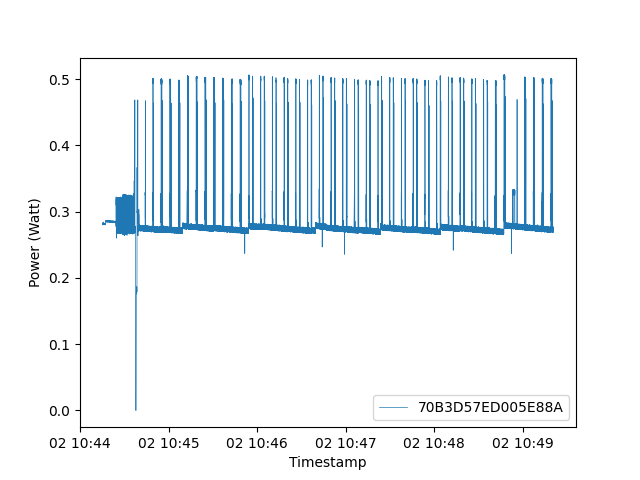

In [10]:
deveui = "70B3D57ED005EA56"

power= %sql select timestamp,power,current,voltage,node_id from Power_Consumption
power = power.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power.groupby("node_id")
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power (Watt)")
plt.legend()
plt.show()

## finding sync signals

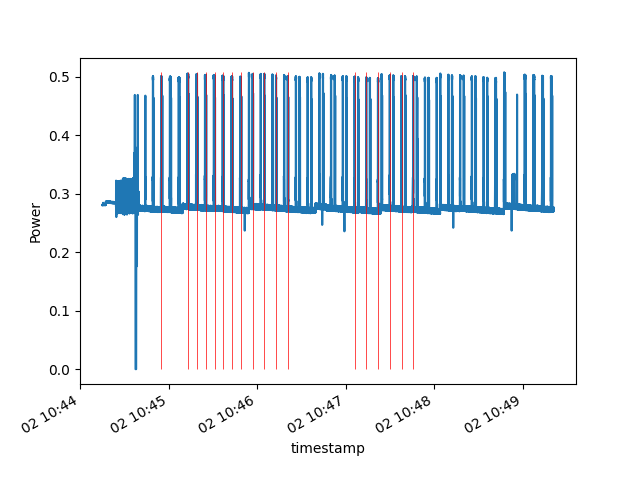

In [11]:
BLINK_HIGH_MS = 200
BLINK_LOW_MS = 200

plt.figure()
plt.ylabel("Power")
# single node
power_single = power[(power["node_id"] =="70B3D57ED005E88A")]
power_single["power"].plot()
power_diff = power_single[(power_single["node_id"] =="70B3D57ED005E88A")]["power"].diff()

filtered_power_diff = power_diff[power_diff < -.2]
plt.vlines(filtered_power_diff.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.show()

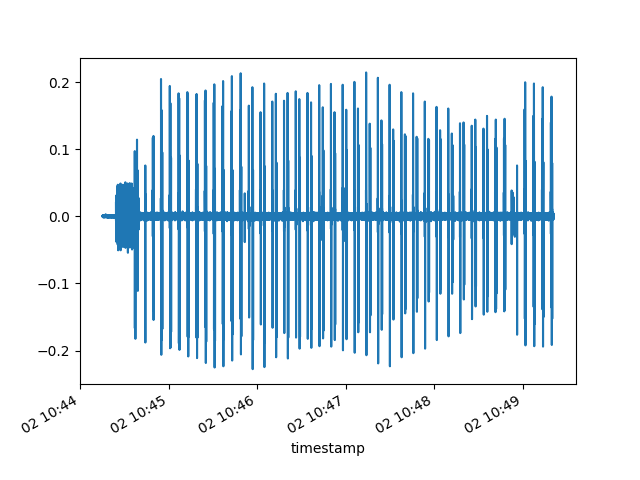

In [12]:
plt.figure()
power_diff.plot()
plt.show()

In [13]:
rising_edge = power_diff[power_diff > 0.1].to_frame()
rising_edge['direction'] = 'rising'
falling_edge = power_diff[power_diff < -0.1].to_frame()
falling_edge['direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges

,power,direction
timestamp,,
2023-11-02 10:44:37.032191,-0.166658,falling
2023-11-02 10:44:37.406171,-0.182531,falling
2023-11-02 10:44:38.493203,0.114158,rising
2023-11-02 10:44:39.032386,-0.111106,falling
2023-11-02 10:44:44.163322,-0.188025,falling
...,...,...
2023-11-02 10:49:19.075489,0.139798,rising
2023-11-02 10:49:19.275539,-0.135525,falling
2023-11-02 10:49:19.492952,0.178258,rising


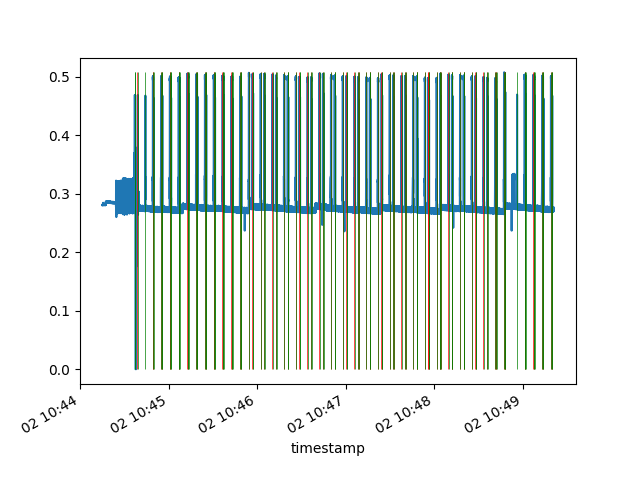

In [14]:
plt.figure()
power_single['power'].plot()
plt.vlines(edges[edges['direction'] == 'rising'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.vlines(edges[edges['direction'] == 'falling'].index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="green", linewidth=0.5)

plt.show()

In [15]:
# only keep edges where direction differ
edges['next_direction'] = edges['direction'].shift(-1)
edges['next_timestamp'] = edges.index.to_series().shift(-1)
edges = edges[(edges['direction'] != edges['next_direction']) & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=210))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=190)))]
edges


,power,direction,next_direction,next_timestamp
timestamp,,,,
2023-11-02 10:44:49.224747,0.117211,rising,falling,2023-11-02 10:44:49.424767
2023-11-02 10:44:54.764450,0.204508,rising,falling,2023-11-02 10:44:54.964469
2023-11-02 10:44:55.181882,0.158112,rising,falling,2023-11-02 10:44:55.381932
2023-11-02 10:45:00.717251,0.194130,rising,falling,2023-11-02 10:45:00.917301
2023-11-02 10:45:01.134713,0.168490,rising,falling,2023-11-02 10:45:01.334733
...,...,...,...,...
2023-11-02 10:49:07.586983,0.197793,rising,falling,2023-11-02 10:49:07.787033
2023-11-02 10:49:13.122535,0.144682,rising,falling,2023-11-02 10:49:13.322555
2023-11-02 10:49:13.539967,0.192298,rising,falling,2023-11-02 10:49:13.739987


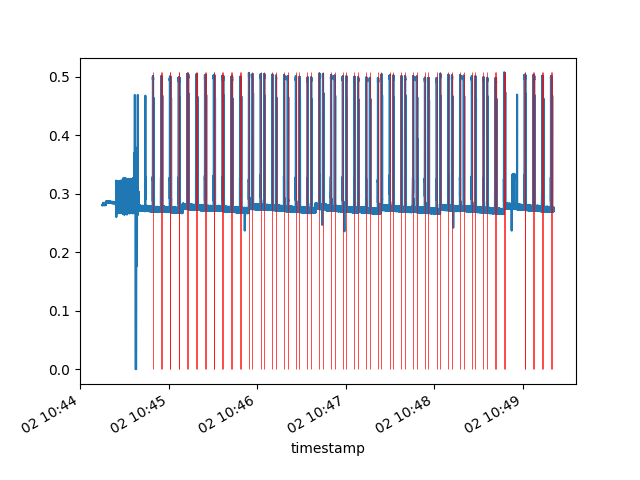

In [24]:
plt.figure()
power_single['power'].plot()
plt.vlines(edges.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.show()

In [16]:
%%sql
res <<
select timestamp, AVG(power) OVER blink AS 'avg_power_blink'
FROM Power_Consumption
WINDOW blink AS (
    PARTITION BY node_id
    ORDER BY timestamp ASC
    RANGE BETWEEN INTERVAL 100 MILLISECOND PRECEDING AND INTERVAL 100 MILLISECOND FOLLOWING
    )

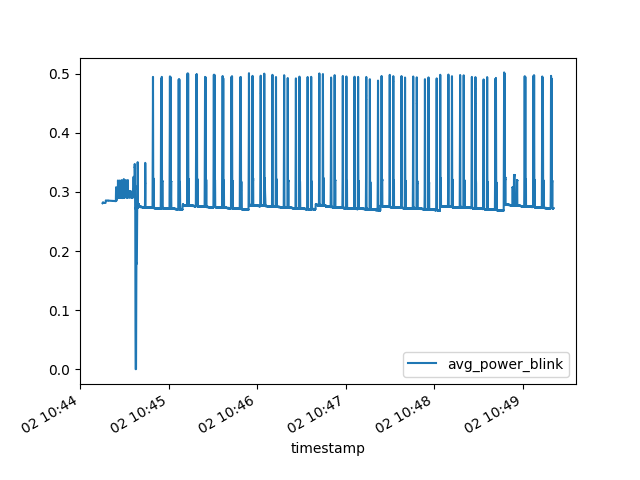

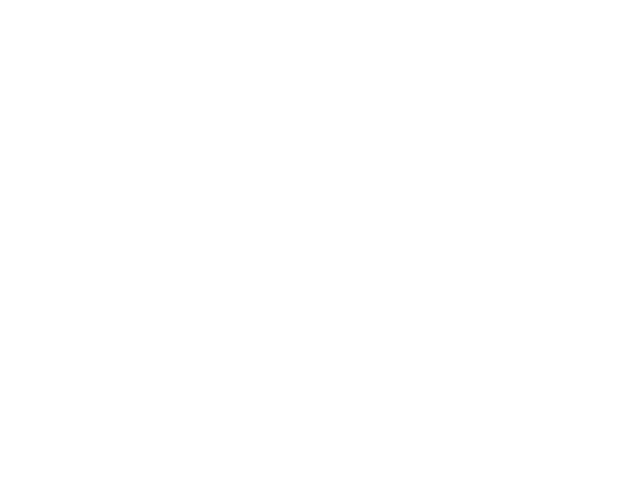

In [17]:
plt.figure()
res.plot(x='timestamp')
plt.show()

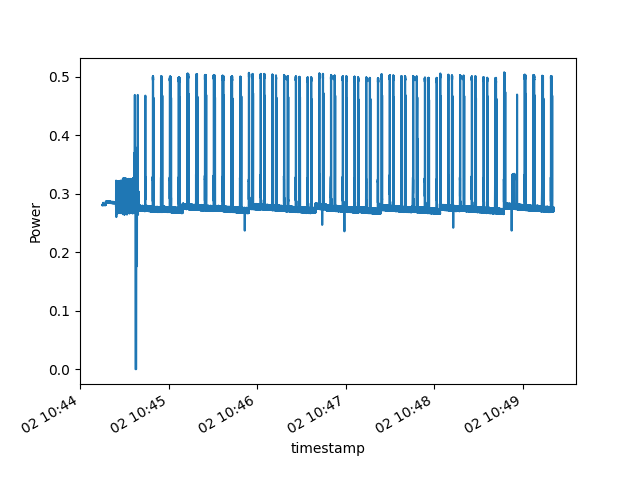

In [18]:
# Clean edge detection
#remove values where difference is not greater or less than 5 seconds
diff = filtered_power_diff.index.to_series().diff(-1).abs()
plt.figure()
plt.ylabel("Power")
# single node

power_single["power"].plot()

plt.vlines(filtered_power_diff.index[(diff < pd.Timedelta(seconds=5.5))  & (diff > pd.Timedelta(seconds=4.5))], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.show()

In [19]:
%sql select count(*) from Trace

,count_star()
0,607


In [20]:
#traces from single node
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A'

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-11-02 10:44:44.111270,�'/!8@!8UP�����Join procedure succeededcreatin...
1,2,70B3D57ED005E88A,2023-11-02 10:44:44.111979,Sending: <3\n
2,3,70B3D57ED005E88A,2023-11-02 10:44:49.218133,"Startup done. Timings: sensor init: 14 ms, env..."
3,4,70B3D57ED005E88A,2023-11-02 10:44:49.220100,Main loop iteration\n
4,5,70B3D57ED005E88A,2023-11-02 10:44:49.222096,Running single blink...\n
...,...,...,...,...
602,603,70B3D57ED005E88A,2023-11-02 10:49:19.918121,collecting data from sensor lps22hb\n
603,604,70B3D57ED005E88A,2023-11-02 10:49:19.924045,Read value from Sensor lps22hb. Saving in env...
604,605,70B3D57ED005E88A,2023-11-02 10:49:19.926032,Execute Queries...\n
605,606,70B3D57ED005E88A,2023-11-02 10:49:19.928118,Sending Responses if any...\n


In [21]:
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A' AND message LIKE '>TIMINGS%'

,trace_id,node_id,timestamp,message


In [22]:
def get_timings_from_trace(trace: str):
    

SyntaxError: incomplete input (2969963752.py, line 2)

In [ ]:
# lower=widgets.SelectionSlider(options=timestamps, value=timestamps.min())
# upper=widgets.SelectionSlider(options=timestamps, value=timestamps.max())
# %sql --save hej --interact deveuis --interact lower --interact upper SELECT * from Power_Consumption where node_id LIKE '{{deveuis}}' AND timestamp BETWEEN '{{lower}}' AND '{{upper}}'